Shapes - X_train: (183112, 48) X_test: (78477, 48)
Shapes - y_train: (183112,) y_test: (78477,)
Shapes after SMOTE - X_train_res: (455199, 48) y_train_res: (455199,)
Epoch 1/10
11380/11380 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step - accuracy: 0.6255 - loss: 0.8287 - val_accuracy: 0.2071 - val_loss: 1.5637
Epoch 2/10
11380/11380 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step - accuracy: 0.6959 - loss: 0.7108 - val_accuracy: 0.1358 - val_loss: 1.6767
Epoch 3/10
11380/11380 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step - accuracy: 0.7195 - loss: 0.6640 - val_accuracy: 0.2580 - val_loss: 1.4336
Epoch 4/10
11380/11380 ━━━━━━━━━━━━━━━━━━━━ 22s 1ms/step - accuracy: 0.7330 - loss: 0.6357 - val_accuracy: 0.2285 - val_loss: 1.5343
Epoch 5/10
11380/11380 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step - accuracy: 0.7421 - loss: 0.6168 - val_accuracy: 0.2041 - val_loss: 1.6297
Epoch 6/10
11380/11380 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step - accuracy: 0.7477 - loss: 0.6035 - val_accuracy: 0.2815 - val_loss: 1.4006
Epoch 7/10
11380/11380 ━━━━━━━━━━━━━


Classification Report for Logistic Regression:
              precision    recall  f1-score   support

         0.0       0.94      0.62      0.75     65029
         1.0       0.04      0.30      0.07      1974
         2.0       0.33      0.58      0.42     11474

    accuracy                           0.61     78477
   macro avg       0.44      0.50      0.41     78477
weighted avg       0.83      0.61      0.68     78477

ROC-AUC Score for Logistic Regression: 0.7404


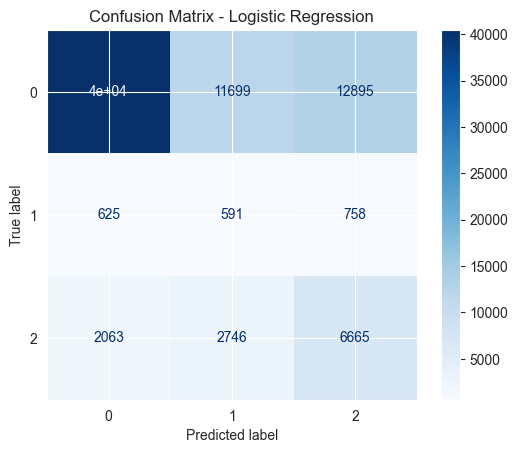


Classification Report for Random Forest:
              precision    recall  f1-score   support

         0.0       0.86      0.92      0.89     65029
         1.0       0.02      0.01      0.01      1974
         2.0       0.38      0.27      0.31     11474

    accuracy                           0.80     78477
   macro avg       0.42      0.40      0.40     78477
weighted avg       0.77      0.80      0.78     78477

ROC-AUC Score for Random Forest: 0.7006


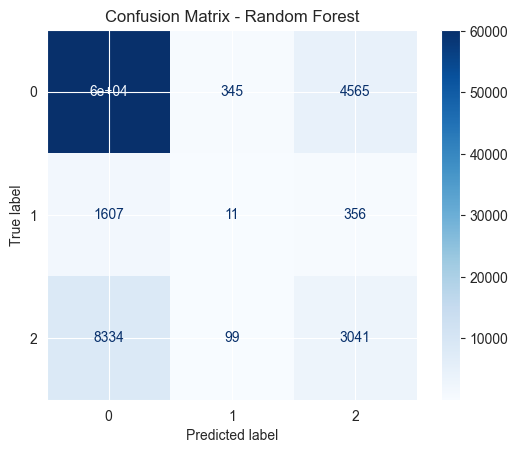

2453/2453 ━━━━━━━━━━━━━━━━━━━━ 2s 651us/step

Classification Report for Neural Network:
              precision    recall  f1-score   support

         0.0       0.88      0.83      0.86     65029
         1.0       0.04      0.17      0.06      1974
         2.0       0.40      0.30      0.34     11474

    accuracy                           0.74     78477
   macro avg       0.44      0.43      0.42     78477
weighted avg       0.79      0.74      0.76     78477

ROC-AUC Score for Neural Network: 0.7499


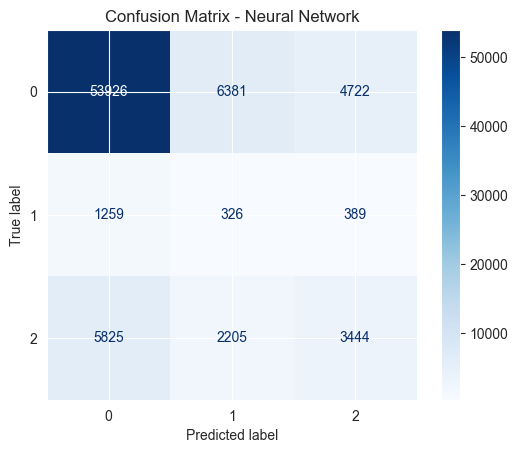

In [9]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from joblib import load, dump
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')  # Ignore deprecation warnings for now

# Define paths
processed_data_path = '../data/processed/'
models_path = '../models/'

# Create models directory if it doesn't exist
os.makedirs(models_path, exist_ok=True)

# Load preprocessed data
X_train = np.load(os.path.join(processed_data_path, 'X_train.npy'))
X_test = np.load(os.path.join(processed_data_path, 'X_test.npy'))
y_train = np.load(os.path.join(processed_data_path, 'y_train.npy'))
y_test = np.load(os.path.join(processed_data_path, 'y_test.npy'))

# Check shapes
print("Shapes - X_train:", X_train.shape, "X_test:", X_test.shape)
print("Shapes - y_train:", y_train.shape, "y_test:", y_test.shape)

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print("Shapes after SMOTE - X_train_res:", X_train_res.shape, "y_train_res:", y_train_res.shape)

# Train Logistic Regression
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
log_reg.fit(X_train_res, y_train_res)
dump(log_reg, os.path.join(models_path, 'logistic_regression_smote.pkl'))

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train_res, y_train_res)
dump(rf_model, os.path.join(models_path, 'random_forest_smote.pkl'))

# Prepare data for Neural Network (one-hot encode y for multi-class)
y_train_cat = to_categorical(y_train_res, num_classes=3)
y_test_cat = to_categorical(y_test, num_classes=3)

# Build and train Neural Network
nn_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_res.shape[1],)),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')  # 3 classes
])
nn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
nn_model.fit(X_train_res, y_train_cat, epochs=10, batch_size=32, validation_split=0.2, verbose=1)
nn_model.save(os.path.join(models_path, 'neural_net.h5'))

# Evaluate all models
models = {'Logistic Regression': log_reg, 'Random Forest': rf_model}
for name, model in models.items():
    y_pred = model.predict(X_test)
    print(f"\nClassification Report for {name}:")
    print(classification_report(y_test, y_pred))
    print(f"ROC-AUC Score for {name}: {roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovr'):.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.show()

# Evaluate Neural Network
y_pred_nn = nn_model.predict(X_test)
y_pred_nn_classes = np.argmax(y_pred_nn, axis=1)
print("\nClassification Report for Neural Network:")
print(classification_report(y_test, y_pred_nn_classes))
print(f"ROC-AUC Score for Neural Network: {roc_auc_score(y_test, y_pred_nn, multi_class='ovr', average='weighted'):.4f}")

cm_nn = confusion_matrix(y_test, y_pred_nn_classes)
disp_nn = ConfusionMatrixDisplay(confusion_matrix=cm_nn)
disp_nn.plot(cmap='Blues')
plt.title('Confusion Matrix - Neural Network')
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV

# Example for Random Forest
param_grid = {'n_estimators': [100, 200], 'max_depth': [10, 20, None]}
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='f1_weighted')
grid_search.fit(X_train_res, y_train_res)
print("Best parameters:", grid_search.best_params_)
dump(grid_search.best_estimator_, os.path.join(models_path, 'random_forest_tuned.pkl'))